# Experiment 6: Encoder-Decoder Architecture

**Objective:** Implement a sequence-to-sequence (Encoder-Decoder) model for **machine translation** from English to Spanish.

We use the **spa.txt** dataset: parallel English–Spanish sentence pairs. The encoder compresses the source sentence into a fixed representation, and the decoder generates the Spanish translation token by token.

## 1. Setup and Imports

We import the required libraries and set random seeds so that results are reproducible.

In [14]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import re

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("PyTorch version:", torch.__version__)
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.9.1+cpu
Device: cpu


## 2. Load and Inspect the Dataset

We load the English–Spanish pairs from **spa.txt**. Each line is tab-separated: `English sentence\tSpanish sentence`. We filter out empty or malformed lines and optionally use a subset so training runs in reasonable time.

In [15]:
# Path to the dataset (same folder as this notebook)
DATA_FILE = "spa.txt"

eng_lines = []
spa_lines = []
with open(DATA_FILE, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if "\t" not in line:
            continue
        parts = line.split("\t", 1)
        if len(parts) == 2 and parts[0].strip() and parts[1].strip():
            eng_lines.append(parts[0].strip())
            spa_lines.append(parts[1].strip())

# Use a subset for faster training (e.g. 50000 pairs). Set to None to use all data.
MAX_PAIRS = 50000
if MAX_PAIRS is not None and len(eng_lines) > MAX_PAIRS:
    eng_lines = eng_lines[:MAX_PAIRS]
    spa_lines = spa_lines[:MAX_PAIRS]

print(f"Total sentence pairs: {len(eng_lines)}")
print("\nExample pairs:")
for i in range(5):
    print(f"  {i+1}. EN: {eng_lines[i][:60]!r}")
    print(f"     ES: {spa_lines[i][:60]!r}")

Total sentence pairs: 50000

Example pairs:
  1. EN: 'Go.'
     ES: 'Ve.'
  2. EN: 'Go.'
     ES: 'Vete.'
  3. EN: 'Go.'
     ES: 'Vaya.'
  4. EN: 'Go.'
     ES: 'Váyase.'
  5. EN: 'Hi.'
     ES: 'Hola.'


## 3. Text Preprocessing and Tokenization

We clean and tokenize each sentence. We use a simple word-level tokenization (split on spaces and keep punctuation attached or separate). For the **target** (Spanish), we add special tokens `<sos>` (start) and `<eos>` (end) so the decoder knows when to start and stop.

In [16]:
# Special tokens
SOS = "<sos>"
EOS = "<eos>"
PAD = "<pad>"
UNK = "<unk>"

def tokenize(sentence):
    """Split into words (keep sequences of letters/numbers and basic punctuation)."""
    # Simple tokenization: split on whitespace; optional: normalize
    tokens = sentence.lower().strip().split()
    return [t for t in tokens if t]

def tokenize_source(sentence):
    """Tokenize source (English): no special tokens at boundaries."""
    return tokenize(sentence)

def tokenize_target(sentence):
    """Tokenize target (Spanish): wrap with <sos> and <eos>."""
    toks = tokenize(sentence)
    return [SOS] + toks + [EOS]

# Tokenize all pairs
eng_tokens = [tokenize_source(s) for s in eng_lines]
spa_tokens = [tokenize_target(s) for s in spa_lines]

print("Example tokenized source:", eng_tokens[0])
print("Example tokenized target:", spa_tokens[0])

Example tokenized source: ['go.']
Example tokenized target: ['<sos>', 've.', '<eos>']


## 4. Vocabulary and Numericalisation

We build separate vocabularies for **source** (English) and **target** (Spanish). Each vocabulary includes special tokens: `<pad>`, `<sos>`, `<eos>`, `<unk>`. We cap the vocabulary size (e.g. top 10k words) so training stays manageable. Then we convert each token sequence to a list of integer indices.

In [17]:
from collections import Counter

VOCAB_SIZE_SRC = 10000   # max words in source vocab
VOCAB_SIZE_TGT = 10000   # max words in target vocab

# Build source vocabulary (English)
src_special = [PAD, UNK]
src_counter = Counter()
for toks in eng_tokens:
    src_counter.update(toks)
src_vocab_list = src_special + [w for w, _ in src_counter.most_common(VOCAB_SIZE_SRC - len(src_special))]
src_word2idx = {w: i for i, w in enumerate(src_vocab_list)}
src_idx2word = {i: w for i, w in enumerate(src_vocab_list)}

# Build target vocabulary (Spanish) — must include PAD, SOS, EOS, UNK
tgt_special = [PAD, SOS, EOS, UNK]
tgt_counter = Counter()
for toks in spa_tokens:
    tgt_counter.update(toks)
# Remove special tokens from count; they're already in tgt_special
for t in tgt_special:
    tgt_counter.pop(t, None)
tgt_vocab_list = tgt_special + [w for w, _ in tgt_counter.most_common(VOCAB_SIZE_TGT - len(tgt_special))]
tgt_word2idx = {w: i for i, w in enumerate(tgt_vocab_list)}
tgt_idx2word = {i: w for i, w in enumerate(tgt_vocab_list)}

PAD_IDX_SRC = src_word2idx[PAD]
PAD_IDX_TGT = tgt_word2idx[PAD]
SOS_IDX = tgt_word2idx[SOS]
EOS_IDX = tgt_word2idx[EOS]

def tokens_to_ids(tokens, word2idx):
    return [word2idx.get(t, word2idx[UNK]) for t in tokens]

# Convert all pairs to integer sequences
src_ids = [tokens_to_ids(t, src_word2idx) for t in eng_tokens]
tgt_ids = [tokens_to_ids(t, tgt_word2idx) for t in spa_tokens]

print(f"Source vocab size: {len(src_word2idx)}")
print(f"Target vocab size: {len(tgt_word2idx)}")
print(f"Max source length: {max(len(s) for s in src_ids)}")
print(f"Max target length: {max(len(s) for s in tgt_ids)}")

Source vocab size: 10000
Target vocab size: 10000
Max source length: 8
Max target length: 14


## 5. Dataset and DataLoader

We create a PyTorch **Dataset** that returns `(source_ids, target_ids)` for each pair. We use a **collate function** to pad sequences in each batch to the same length (using `<pad>` token id) so we can stack them into tensors.

In [18]:
def pad_sequence(ids, pad_idx, max_len=None):
    """Pad a list of ids to max_len with pad_idx. If max_len is None, use the max length in the batch."""
    if max_len is None:
        max_len = max(len(x) for x in ids)
    padded = []
    for x in ids:
        padded.append(x + [pad_idx] * (max_len - len(x)))
    return padded

def collate_fn(batch):
    """Batch is a list of (src_ids, tgt_ids). Pad both to max length in batch."""
    src_batch = [b[0] for b in batch]
    tgt_batch = [b[1] for b in batch]
    src_len = max(len(s) for s in src_batch)
    tgt_len = max(len(t) for t in tgt_batch)
    src_padded = pad_sequence(src_batch, PAD_IDX_SRC, src_len)
    tgt_padded = pad_sequence(tgt_batch, PAD_IDX_TGT, tgt_len)
    return (
        torch.tensor(src_padded, dtype=torch.long),
        torch.tensor(tgt_padded, dtype=torch.long),
    )

class TranslationDataset(Dataset):
    def __init__(self, src_ids, tgt_ids):
        self.src_ids = src_ids
        self.tgt_ids = tgt_ids

    def __len__(self):
        return len(self.src_ids)

    def __getitem__(self, idx):
        return (self.src_ids[idx], self.tgt_ids[idx])

dataset = TranslationDataset(src_ids, tgt_ids)
BATCH_SIZE = 64
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# Sanity check: one batch
src_b, tgt_b = next(iter(dataloader))
print(f"Source batch shape: {src_b.shape}")
print(f"Target batch shape: {tgt_b.shape}")

Source batch shape: torch.Size([64, 7])
Target batch shape: torch.Size([64, 9])


## 6. Encoder-Decoder (Seq2Seq) Model

We define:
- **Encoder**: Embedding layer + LSTM. It reads the source sequence and outputs a final hidden state (and cell state) that summarises the whole sentence.
- **Decoder**: Embedding layer + LSTM. It is initialised with the encoder’s final state. At each step it takes the previous token (during training we use the true previous token — *teacher forcing*) and produces logits over the target vocabulary.
- **Seq2Seq**: Wires encoder and decoder together. Input: source ids and target ids (for teacher forcing). Output: logits of shape `(batch, target_len, target_vocab_size)`.

In [19]:
EMBED_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 1
DROPOUT = 0.3

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX_SRC)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, src):
        # src: (batch, src_len)
        x = self.embed(src)  # (batch, src_len, embed_dim)
        _, (h_n, c_n) = self.lstm(x)
        return h_n, c_n  # each (num_layers, batch, hidden_dim)

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX_TGT)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, tgt, h_c):
        # tgt: (batch, tgt_len); h_c = (h_n, c_n) from encoder
        x = self.embed(tgt)  # (batch, tgt_len, embed_dim)
        out, new_h_c = self.lstm(x, h_c)  # out: (batch, tgt_len, hidden_dim)
        logits = self.fc(out)  # (batch, tgt_len, vocab_size)
        return logits, new_h_c

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt):
        # Teacher forcing: decoder input is tgt (full target sequence)
        h_c = self.encoder(src)
        # Decoder input: we feed tgt as input; we'll use tgt[:, :-1] for predicting tgt[:, 1:]
        tgt_input = tgt[:, :-1]  # drop last token (we predict it)
        logits, _ = self.decoder(tgt_input, h_c)  # (batch, tgt_len-1, tgt_vocab)
        return logits

encoder = Encoder(len(src_word2idx), EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
decoder = Decoder(len(tgt_word2idx), EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder)

# Quick shape check
with torch.no_grad():
    logits = model(src_b, tgt_b)
print(f"Decoder logits shape: {logits.shape}  (batch, tgt_len-1, tgt_vocab_size)")

Decoder logits shape: torch.Size([64, 8, 10000])  (batch, tgt_len-1, tgt_vocab_size)


## 7. Training Loop

We train the model by minimising **cross-entropy loss** between the decoder’s logits and the target tokens (shifted by one: we predict the next token). We use **teacher forcing**: the decoder input at each step is the true previous token from the target. We ignore padding positions in the loss using `ignore_index=PAD_IDX_TGT`.

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX_TGT)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

NUM_EPOCHS = 7

In [21]:
train_losses = []  # store per-epoch loss for plotting
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0
    num_batches = 0
    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        logits = model(src, tgt)  # (batch, tgt_len-1, vocab)
        targets = tgt[:, 1:]      # (batch, tgt_len-1) — next token at each step
        loss = criterion(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    avg_loss = total_loss / num_batches
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} — Train loss: {avg_loss:.4f}")

Epoch 1/7 — Train loss: 4.0699
Epoch 2/7 — Train loss: 2.2826
Epoch 3/7 — Train loss: 1.4160
Epoch 4/7 — Train loss: 0.8948
Epoch 5/7 — Train loss: 0.5914
Epoch 6/7 — Train loss: 0.4246
Epoch 7/7 — Train loss: 0.3368


## 8. Inference and Example Translations

We run **greedy decoding**: encode the source sentence, then feed the decoder one token at a time. We start with `<sos>` and at each step take the token with the highest logit; we stop when we generate `<eos>` or hit a maximum length. We show a few example translations side by side with the reference Spanish.

In [22]:
MAX_DECODE_LEN = 50

def translate(model, src_ids, src_word2idx, tgt_idx2word, device, max_len=MAX_DECODE_LEN):
    """Translate one source sequence (list of token ids) to a list of output token ids (greedy)."""
    model.eval()
    with torch.no_grad():
        src_t = torch.tensor([src_ids], dtype=torch.long, device=device)
        h_c = model.encoder(src_t)
        # Start with SOS
        prev = torch.tensor([[SOS_IDX]], device=device)
        out_ids = []
        for _ in range(max_len - 1):
            logits, h_c = model.decoder(prev, h_c)  # (1, 1, vocab); carry state for next step
            next_id = logits.argmax(dim=-1).squeeze().item()
            out_ids.append(next_id)
            if next_id == EOS_IDX:
                break
            prev = torch.tensor([[next_id]], device=device)
    return out_ids

def ids_to_sentence(ids, idx2word, strip_special=True):
    if strip_special:
        ids = [i for i in ids if i not in (SOS_IDX, EOS_IDX, PAD_IDX_TGT)]
    return " ".join(idx2word.get(i, UNK) for i in ids)

In [23]:
# Pick a few examples and show translation
num_examples = 8
indices = np.linspace(0, len(eng_lines) - 1, num_examples, dtype=int)

print("Sample translations (EN -> reference ES -> model ES):\n")
for idx in indices:
    en_sent = eng_lines[idx]
    ref_spa = spa_lines[idx]
    src_id_list = src_ids[idx]
    out_ids = translate(model, src_id_list, src_word2idx, tgt_idx2word, device)
    pred_spa = ids_to_sentence(out_ids, tgt_idx2word)
    print(f"EN:  {en_sent}")
    print(f"REF: {ref_spa}")
    print(f"OUT: {pred_spa}")
    print()

Sample translations (EN -> reference ES -> model ES):

EN:  Go.
REF: Ve.
OUT: nos da <unk>

EN:  We already ate.
REF: Nosotros ya comimos.
OUT: nosotros ya <unk>

EN:  She tried to swim.
REF: Ella intentó nadar.
OUT: ella intentó nadar.

EN:  That's good to know.
REF: Es bueno saberlo.
OUT: es bueno para saber.

EN:  Let's go to the beach.
REF: ¡Vámonos a la playa!
OUT: vamos a ir a la playa.

EN:  I bought a Nintendo 3DS.
REF: Me compré un Nintendo 3DS.
OUT: me compré un <unk> <unk>

EN:  What does this device do?
REF: ¿Qué hace este aparato?
OUT: ¿qué hace este <unk>

EN:  The people are so friendly.
REF: La gente es muy amable.
OUT: la gente es muy amable.



## 9. Graphs and Results Evaluation

We plot the **training loss curve** and compute **evaluation metrics**: BLEU score (translation quality) and **word-level accuracy** on a held-out sample.

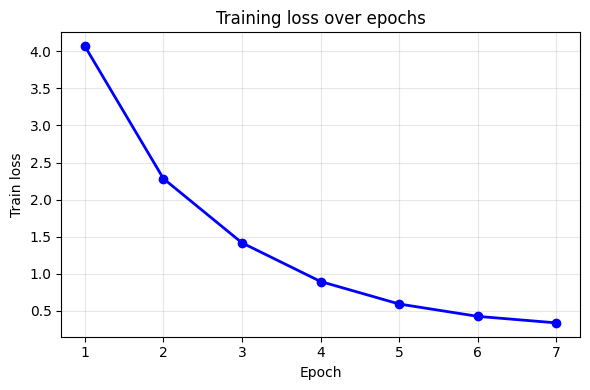

In [24]:
import matplotlib.pyplot as plt

# train_losses is filled by the training loop cell above — run that cell first
if 'train_losses' not in dir() or len(train_losses) == 0:
    print("Run the 'Training Loop' cell (Section 7) first so train_losses is defined.")
    train_losses = []

plt.figure(figsize=(6, 4))
if train_losses:
    plt.plot(range(1, len(train_losses) + 1), train_losses, "b-o", linewidth=2, markersize=6)
    plt.xlabel("Epoch")
    plt.ylabel("Train loss")
    plt.title("Training loss over epochs")
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, "No training data.\nRun the training loop above first.", ha='center', va='center', fontsize=12)
    plt.title("Training loss over epochs")
plt.tight_layout()
plt.show()

In [25]:
# Evaluation: BLEU score and word-level accuracy on a sample
import warnings
try:
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
except ImportError:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nltk", "-q"])
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Smoothing avoids 0 n-gram overlap warnings and gives stable scores for short hypotheses
smoothing = SmoothingFunction().method1

# Use a fixed sample for evaluation (same every run)
EVAL_SIZE = 300
np.random.seed(42)
eval_indices = np.random.choice(len(eng_lines), size=min(EVAL_SIZE, len(eng_lines)), replace=False)

bleu_scores = []
word_correct, word_total = 0, 0

with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # suppress BLEU n-gram warnings when using smoothing
    for idx in eval_indices:
        src_id_list = src_ids[idx]
        ref_tokens = spa_tokens[idx][1:-1]  # strip <sos> and <eos>
        out_ids = translate(model, src_id_list, src_word2idx, tgt_idx2word, device)
        pred_tokens = [tgt_idx2word.get(i, UNK) for i in out_ids if i not in (SOS_IDX, EOS_IDX, PAD_IDX_TGT)]

        # BLEU with smoothing (reference = list of token lists)
        ref = [ref_tokens]
        bleu = sentence_bleu(ref, pred_tokens, smoothing_function=smoothing)
        bleu_scores.append(bleu)

        # Word-level accuracy: compare position by position
        for i in range(max(len(ref_tokens), len(pred_tokens))):
            word_total += 1
            if i < len(ref_tokens) and i < len(pred_tokens) and ref_tokens[i] == pred_tokens[i]:
                word_correct += 1

avg_bleu = np.mean(bleu_scores) * 100
word_acc = (word_correct / word_total * 100) if word_total > 0 else 0.0

# Results in tabular format
import pandas as pd
results_table = pd.DataFrame({
    "Metric": ["Sample size (sentences)", "Average BLEU (%)", "Word-level accuracy (%)"],
    "Value": [len(eval_indices), f"{avg_bleu:.2f}", f"{word_acc:.2f}"]
})
print("\n" + "=" * 42)
print("         EVALUATION RESULTS")
print("=" * 42)
print(results_table.to_string(index=False))
print("=" * 42)


         EVALUATION RESULTS
                 Metric Value
Sample size (sentences)   300
       Average BLEU (%) 50.28
Word-level accuracy (%) 65.61


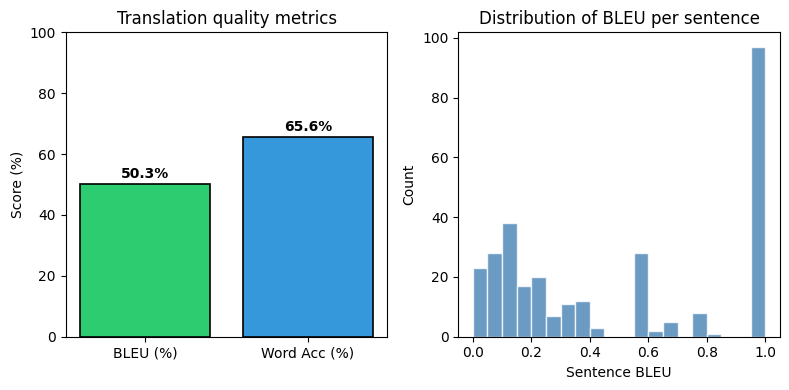

In [26]:
# Bar chart of evaluation metrics
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].bar(["BLEU (%)", "Word Acc (%)"], [avg_bleu, word_acc], color=["#2ecc71", "#3498db"], edgecolor="black", linewidth=1.2)
ax[0].set_ylabel("Score (%)")
ax[0].set_title("Translation quality metrics")
ax[0].set_ylim(0, 100)
for i, v in enumerate([avg_bleu, word_acc]):
    ax[0].text(i, v + 2, f"{v:.1f}%", ha="center", fontweight="bold")

ax[1].hist(bleu_scores, bins=20, color="steelblue", edgecolor="white", alpha=0.8)
ax[1].set_xlabel("Sentence BLEU")
ax[1].set_ylabel("Count")
ax[1].set_title("Distribution of BLEU per sentence")
plt.tight_layout()
plt.show()

---

**Summary:** We built an Encoder-Decoder (seq2seq) model for English-to-Spanish translation using the spa.txt dataset. The encoder compresses each source sentence into a hidden state; the decoder generates the translation token by token using teacher forcing during training and greedy decoding at inference. You can increase `MAX_PAIRS` or `NUM_EPOCHS` for better quality, or add an attention mechanism for longer sentences.

## 10. Improving Accuracy and Comparison

To improve translation quality we train an **improved model** with:
- **Bidirectional encoder**: reads the source sentence both left-to-right and right-to-left, then merges the two final states so the decoder gets a richer representation.
- **2 LSTM layers** in encoder and decoder (more capacity).
- **Learning-rate scheduler**: reduce learning rate when validation loss plateaus (we use training loss here for simplicity).
- **More epochs** (8 instead of 5).

We then compare **Baseline** (current model) vs **Improved** on BLEU and word accuracy in a table and bar chart.

In [27]:
# Save baseline metrics (from the evaluation cell above — run Section 9 first)
try:
    baseline_bleu = avg_bleu
    baseline_acc = word_acc
except NameError:
    baseline_bleu, baseline_acc = 0.0, 0.0
    print("Run the evaluation cell (Section 9) first to set baseline. Using 0 for now.")

# Bidirectional Encoder: LSTM reads both directions, then we project 2*hidden -> hidden for decoder
class EncoderBidir(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX_SRC)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc_h = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc_c = nn.Linear(2 * hidden_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, src):
        x = self.embed(src)
        _, (h_n, c_n) = self.lstm(x)   # h_n, c_n: (2*num_layers, batch, hidden_dim)
        # Merge forward and backward for last layer
        h_fwd, h_bwd = h_n[-2], h_n[-1]
        h_merged = self.fc_h(torch.cat([h_fwd, h_bwd], dim=-1))  # (batch, hidden_dim)
        c_fwd, c_bwd = c_n[-2], c_n[-1]
        c_merged = self.fc_c(torch.cat([c_fwd, c_bwd], dim=-1))
        return h_merged.unsqueeze(0), c_merged.unsqueeze(0)  # (1, batch, hidden_dim)

# Improved hyperparameters
EMBED_IMP = 256
HIDDEN_IMP = 512
NUM_LAYERS_IMP = 2
DROPOUT_IMP = 0.3
NUM_EPOCHS_IMP = 8

encoder_imp = EncoderBidir(len(src_word2idx), EMBED_IMP, HIDDEN_IMP, NUM_LAYERS_IMP, DROPOUT_IMP)
decoder_imp = Decoder(len(tgt_word2idx), EMBED_IMP, HIDDEN_IMP, 1, DROPOUT_IMP)
model_improved = Seq2Seq(encoder_imp, decoder_imp).to(device)
optimizer_imp = torch.optim.Adam(model_improved.parameters(), lr=1e-3)
scheduler_imp = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_imp, mode="min", factor=0.5, patience=1)
criterion_imp = nn.CrossEntropyLoss(ignore_index=PAD_IDX_TGT)
print("Improved model (bidirectional encoder, 2 layers) created.")

Improved model (bidirectional encoder, 2 layers) created.


In [28]:
# Train improved model
train_losses_imp = []
for epoch in range(NUM_EPOCHS_IMP):
    model_improved.train()
    total_loss = 0.0
    num_batches = 0
    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer_imp.zero_grad()
        logits = model_improved(src, tgt)
        targets = tgt[:, 1:]
        loss = criterion_imp(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_improved.parameters(), 1.0)
        optimizer_imp.step()
        total_loss += loss.item()
        num_batches += 1
    avg_loss = total_loss / num_batches
    train_losses_imp.append(avg_loss)
    scheduler_imp.step(avg_loss)
    print(f"Improved — Epoch {epoch+1}/{NUM_EPOCHS_IMP} — Train loss: {avg_loss:.4f}")

Improved — Epoch 1/8 — Train loss: 4.4397
Improved — Epoch 2/8 — Train loss: 2.8980
Improved — Epoch 3/8 — Train loss: 2.1284
Improved — Epoch 4/8 — Train loss: 1.5985
Improved — Epoch 5/8 — Train loss: 1.2062
Improved — Epoch 6/8 — Train loss: 0.9161
Improved — Epoch 7/8 — Train loss: 0.7076
Improved — Epoch 8/8 — Train loss: 0.5648


In [29]:
# Evaluate improved model on the same sample
import warnings
smoothing = SmoothingFunction().method1
bleu_scores_imp = []
word_correct_imp, word_total_imp = 0, 0
np.random.seed(42)
eval_indices_imp = np.random.choice(len(eng_lines), size=min(EVAL_SIZE, len(eng_lines)), replace=False)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for idx in eval_indices_imp:
        src_id_list = src_ids[idx]
        ref_tokens = spa_tokens[idx][1:-1]
        out_ids = translate(model_improved, src_id_list, src_word2idx, tgt_idx2word, device)
        pred_tokens = [tgt_idx2word.get(i, UNK) for i in out_ids if i not in (SOS_IDX, EOS_IDX, PAD_IDX_TGT)]
        ref = [ref_tokens]
        bleu_scores_imp.append(sentence_bleu(ref, pred_tokens, smoothing_function=smoothing))
        for i in range(max(len(ref_tokens), len(pred_tokens))):
            word_total_imp += 1
            if i < len(ref_tokens) and i < len(pred_tokens) and ref_tokens[i] == pred_tokens[i]:
                word_correct_imp += 1

improved_bleu = np.mean(bleu_scores_imp) * 100
improved_acc = (word_correct_imp / word_total_imp * 100) if word_total_imp > 0 else 0.0
print(f"Improved model — BLEU: {improved_bleu:.2f}%  Word accuracy: {improved_acc:.2f}%")

Improved model — BLEU: 45.50%  Word accuracy: 62.22%



         BASELINE vs IMPROVED — COMPARISON
   Model  BLEU (%)  Word accuracy (%)
Baseline 50.279918          65.605590
Improved 45.504600          62.220509


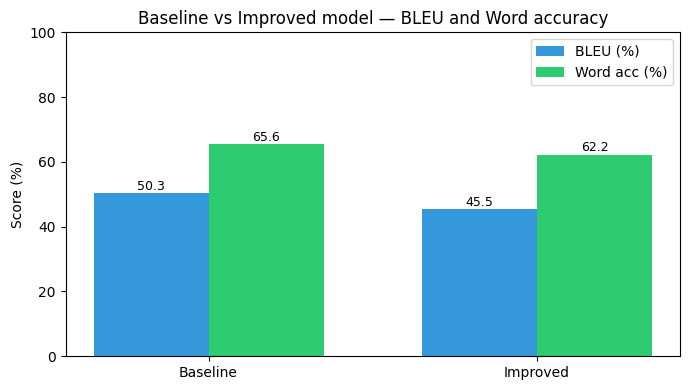

In [30]:
# Comparison table and bar chart
import pandas as pd
comparison = pd.DataFrame({
    "Model": ["Baseline", "Improved"],
    "BLEU (%)": [baseline_bleu, improved_bleu],
    "Word accuracy (%)": [baseline_acc, improved_acc],
})
print("\n" + "=" * 52)
print("         BASELINE vs IMPROVED — COMPARISON")
print("=" * 52)
print(comparison.to_string(index=False))
print("=" * 52)

# Grouped bar chart
fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(2)
width = 0.35
bars1 = ax.bar(x - width/2, [baseline_bleu, improved_bleu], width, label="BLEU (%)", color="#3498db")
bars2 = ax.bar(x + width/2, [baseline_acc, improved_acc], width, label="Word acc (%)", color="#2ecc71")
ax.set_ylabel("Score (%)")
ax.set_xticks(x)
ax.set_xticklabels(["Baseline", "Improved"])
ax.legend()
ax.set_ylim(0, 100)
for b in bars1:
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 1, f"{b.get_height():.1f}", ha="center", fontsize=9)
for b in bars2:
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 1, f"{b.get_height():.1f}", ha="center", fontsize=9)
ax.set_title("Baseline vs Improved model — BLEU and Word accuracy")
plt.tight_layout()
plt.show()